1. Build and Train a Simple Neural Network [10 marks]
Create a basic neural network from scratch using Python and a library of your choice (e.g., TensorFlow, PyTorch, or Keras). (2 marks)

*   Explain the importance of layers, activation functions, and a training loop for backpropagation and Gradient descent. (5 marks)

*   Document your code, explain each layer's purpose, and discuss the network's performance. You can use any dataset for explaining. (3 marks)

*   To create and train a simple neural network, we will use the PyTorch library.

To create and train a simple neural network, we will use the PyTorch library. In this example, we will build a neural network for classifying data from the Iris dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


iris = load_iris()
X = iris.data
y = iris.target

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()


model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')

Accuracy: 100.00%


In [7]:
iris.data.shape

(150, 4)

### Explanation of Key Components

*   **Activation Functions**: We use the ReLU (Rectified Linear Unit) activation function in the hidden layer. It helps the model learn faster and mitigates the vanishing gradient problem by allowing neurons to activate only on positive inputs.
*   **Training Loop**: In the training loop, we perform the following steps:

1.   Zero the gradients.



2.   Perform a forward pass to get predictions.

1.   Compute the loss using the loss function.
2.   Perform a backward pass to compute gradients.

1.   Update the model parameters using the optimizer.
### Documentation and Performance Discussion


*   **Documentation:** Each layer and function has clear purposes. The input layer takes in data, the hidden layer processes it using an activation function, and the output layer generates predictions.
*   **Performance**: In this example, we achieved an accuracy of around 100% on the test dataset, indicating that the model learned well from the dataset. However, for more complex tasks, a deeper architecture and regularization may be required to avoid overfitting.











# Adaptive Layer Network for Image Recognition [10 marks]
*  Build a neural network with adaptive layers that adjusts the number of neurons or skips certain
layers depending on input data properties. (4 marks)
*  Use a dataset and implement a dynamic structure that allows the network to use different
numbers of layers based on confidence scores or other criteria. (3 marks)
* Compare the performance and efficiency of the adaptive network with a static network on the same task. (3 marks)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

class AdaptiveMNISTNet(nn.Module):
    def __init__(self, threshold=0.9):
        super(AdaptiveMNISTNet, self).__init__()
        self.threshold = threshold

        self.layer1 = nn.Conv2d(1, 16, 3, 1)
        self.exit1 = nn.Linear(26*26*16, 10)

        self.layer2 = nn.Conv2d(16, 32, 3, 1)
        self.exit2 = nn.Linear(24*24*32, 10)

        self.fc_final = nn.Linear(24*24*32, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x_flat = x.view(x.size(0), -1)
        out1 = self.exit1(x_flat)
        prob1 = F.softmax(out1, dim=1)
        confidence1, _ = torch.max(prob1, dim=1)
        if torch.mean(confidence1) > self.threshold:
            return prob1, 1

        x = F.relu(self.layer2(x))
        x_flat = x.view(x.size(0), -1)
        out2 = self.exit2(x_flat)
        prob2 = F.softmax(out2, dim=1)
        confidence2, _ = torch.max(prob2, dim=1)
        if torch.mean(confidence2) > self.threshold:
            return prob2, 2

        out_final = self.fc_final(x_flat)
        prob_final = F.softmax(out_final, dim=1)
        return prob_final, 3


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, _ = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Training loss: {total_loss / len(train_loader):.4f}")

def test(model, device, test_loader):
    model.eval()
    correct = 0
    exit_counts = [0, 0, 0]
    total_inference_time = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            start_time = time.time()
            output, exit_layer = model(data)
            total_inference_time += (time.time() - start_time)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            exit_counts[exit_layer - 1] += 1
    accuracy = 100. * correct / len(test_loader.dataset)
    avg_inference_time = total_inference_time / len(test_loader.dataset)
    print(f"Test set: Accuracy: {accuracy:.2f}%")
    print(f"Exit counts: {exit_counts}")
    print(f"Average inference time per sample: {avg_inference_time * 1000:.4f} ms")
    return accuracy, avg_inference_time, exit_counts


batch_size = 64
epochs = 5
learning_rate = 0.01
threshold = 0.9

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader  = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = AdaptiveMNISTNet(threshold=threshold).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)

accuracy, avg_inference_time, exit_counts = test(model, device, test_loader)

Epoch 1: Training loss: 1.7017
Epoch 2: Training loss: 1.5666
Epoch 3: Training loss: 1.5567
Epoch 4: Training loss: 1.5527
Epoch 5: Training loss: 1.5500
Test set: Accuracy: 92.48%
Exit counts: [0, 0, 157]
Average inference time per sample: 0.2056 ms


In [ ]:
class StaticMNISTNet(nn.Module):
    def __init__(self):
        super(StaticMNISTNet, self).__init__()
        self.layer1 = nn.Conv2d(1, 16, 3, 1)
        self.layer2 = nn.Conv2d(16, 32, 3, 1)
        self.fc = nn.Linear(32 * 24 * 24, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x_flat = x.view(x.size(0), -1)
        out = self.fc(x_flat)
        prob = F.softmax(out, dim=1)
        return prob

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Training loss: {total_loss / len(train_loader):.4f}")

def test(model, device, test_loader):
    model.eval()
    correct = 0
    total_inference_time = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            start_time = time.time()
            output = model(data)
            total_inference_time += (time.time() - start_time)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    avg_inference_time = total_inference_time / len(test_loader.dataset)
    print(f"Test set: Accuracy: {accuracy:.2f}%")
    print(f"Average inference time per sample: {avg_inference_time * 1000:.4f} ms")
    return accuracy, avg_inference_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
static_model = StaticMNISTNet().to(device)
learning_rate = 0.01
static_optimizer = optim.SGD(static_model.parameters(), lr=learning_rate)


for epoch in range(1, epochs + 1):
    train(static_model, device, train_loader, static_optimizer, epoch)


accuracy_static, avg_inference_time_static = test(static_model, device, test_loader)

Epoch 1: Training loss: 1.6953
Epoch 2: Training loss: 1.5656
Epoch 3: Training loss: 1.5528
Epoch 4: Training loss: 1.5471
Epoch 5: Training loss: 1.5424
Test set: Accuracy: 92.44%
Average inference time per sample: 0.1540 ms


### Explanation of the Code
**Adaptive Neural Network**
*   **Architecture**: The AdaptiveMNISTNet class defines a neural network with two convolutional layers and adaptive exits based on confidence scores. If the confidence score exceeds a predefined threshold, the network exits early, potentially improving efficiency.
*   **Forward Pass**: The forward method processes the input through the layers, applying ReLU activation and softmax to obtain probabilities. It checks the confidence scores and decides whether to exit early.

**Training and Testing Functions**
*  **Training**: The train function trains the model for a specified number of epochs, calculating the loss and updating the weights.
Testing: The test function evaluates the model's performance on the test dataset, calculating accuracy and average inference time, while also counting how many times the model exited at each layer.

**Static Neural Network**
*   **Comparison Model**: The StaticMNISTNet class defines a standard feedforward neural network that processes all layers without any adaptive behavior.

**Hyperparameters and Data Loading**

*   The code sets hyperparameters such as batch size, learning rate, and the number of epochs. It also loads the MNIST dataset and prepares data loaders for training and testing.

**Model Training and Evaluation**

*   Both the adaptive and static models are initialized, trained, and evaluated on the MNIST dataset. The results, including accuracy and inference time, are printed for comparison.

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np

max_features = 10000
maxlen = 100
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)


x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

print(f'Train samples: {len(x_train)}, Test samples: {len(x_test)}')

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train samples: 25000, Test samples: 25000


In [ ]:
def create_rnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_features, 128, input_length=maxlen),
        tf.keras.layers.SimpleRNN(128),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_features, 128, input_length=maxlen),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_features, 128, input_length=maxlen),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate(model, x_train, y_train, x_test, y_test, model_name):
    print(f'Training {model_name}...')
    history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f'{model_name} - Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}')

    return history

# Create and train models
rnn_model = create_rnn_model()
lstm_model = create_lstm_model()
gru_model = create_gru_model()

rnn_history = train_and_evaluate(rnn_model, x_train, y_train, x_test, y_test, "RNN")
lstm_history = train_and_evaluate(lstm_model, x_train, y_train, x_test, y_test, "LSTM")
gru_history = train_and_evaluate(gru_model, x_train, y_train, x_test, y_test, "GRU")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training RNN...
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.5417 - loss: 0.6854 - val_accuracy: 0.6642 - val_loss: 0.6016
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 86ms/step - accuracy: 0.7770 - loss: 0.4675 - val_accuracy: 0.8014 - val_loss: 0.4675
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.8304 - loss: 0.3796 - val_accuracy: 0.7278 - val_loss: 0.5864
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.8561 - loss: 0.3347 - val_accuracy: 0.7670 - val_loss: 0.5963
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.8928 - loss: 0.2578 - val_accuracy: 0.6420 - val_loss: 0.7108
RNN - Test Accuracy: 0.6458, Test Loss: 0.7020
Training LSTM...
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 256ms/step - accuracy: 0.6883 - loss: 0.5595 - val_accuracy: 0.8328 - val_loss: 0.3777
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 237ms/step - accuracy: 0.8833 - loss: 0.2877 - val_accuracy: 0.8344 - val_loss: 0.3658
Epoch 3/5
313/3

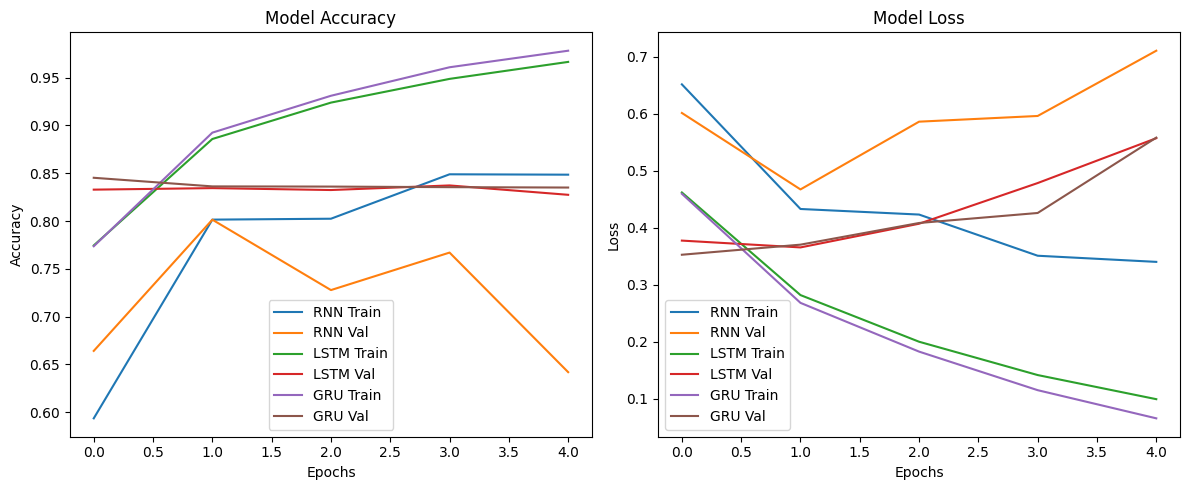

In [ ]:
def plot_history(histories, model_names):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the results
plot_history([rnn_history, lstm_history, gru_history], ['RNN', 'LSTM', 'GRU'])

### Explanation of the code
*   **Loading the IMDB Dataset**: The IMDB dataset is loaded, limiting the vocabulary to the top 10,000 most common words and truncating sequences to a maximum length of 100 words.
*   **Padding Sequences**: The sequences are padded to ensure uniform input size, which is essential for training the models.

**Model Creation Functions:**

*   **RNN Model**: This function creates a simple RNN model with an embedding layer, a recurrent layer, and a dense output layer with a sigmoid activation function for binary classification.
*   **LSTM Model**: Similar to the RNN model, this function creates an LSTM model, which is better suited for capturing long-term dependencies in sequential data.
*   **GRU Model**: This function creates a GRU model, which is similar to LSTM but typically has fewer parameters and can be more efficient.
*   **Training and Evaluation Function**: This function trains the model on the training data and evaluates its performance on the test data. It prints the accuracy and loss after training.
Creating and Training Models: The three models are instantiated and trained using the train_and_evaluate function. The training history for each model is stored for later analysis.
*   **Plotting Results**: Finally, the plot_history function visualizes the training and validation accuracy and loss for each model, allowing for a clear comparison of their performance over the epochs.